# Machine Learning at Scale
Dr. James G. Shanahan and Marguerite Oneto, with assistance from Kasane Utsumi   
&copy; copyright July 2016


# The Heritage Health Prize Challenge Using Spark

### Improve Healthcare, Win \$3,000,000.  Identify patients who will be admitted to a hospital within the next year using historical claims data.  

This notebook uses Spark to build a basic pipeline for modeling outcomes using the Heritage Health Prize dataset.  The notebook is organized as follows:

1.  **Introduction**
2.  **Set Up Spark**
3.  **ETL**
4.  **Feature Engineering**
5.  **Modeling, Evaluation, and Tuning**
6.  **Results**
7.  **Next Steps**
8.  **Resources**
9.  **Appendix**

## Table of Contents <a name="TOC"></a> 
1.  [Introduction](#1)
    1.  [Executive Summary](#1.A)
    2.  [System Set-Up](#1.B)
    3.  [Required Python Modules](#1.C)
2.  [Set Up Spark](#2)
    1.  [Local Set-Up](#2.A)
    2.  [Docker Set-Up](#2.B)
    3.  [Cluster Set-Up](#2.C)
3.  [ETL (Extract-Transform-Load Data)](#3)
    1.  [Target Variables](#3.A)
    2.  [Claims Data](#3.B)
    3.  [Drug Data](#3.C)
    4.  [Lab Data](#3.D)
    5.  [Members Data](#3.E)
4.  [Feature Engineering](#4)
    1.  [Aggregation](#4.A)
        1.  [Aggregate and Merge Data](#4.A.a)
        2.  [Create Aggregated DataFrame](#4.A.b)
        3.  [External Storage Read/Write DataFrame](#4.A.c)
        4.  [EDA](#4.A.d)
    2.  [One Hot Encoding](#4.B)
        1.  [Create DataFrame for One Hot Encoding](#4.B.a)
        2.  [One Hot Encode Features Using Spark Pipelines](#4.B.b)
        3.  [Create OHE DataFrame](#4.B.c)
        4.  [External Storage Read/Write DataFrame](#4.B.d)
        5.  [EDA](#4.B.e)
    3.  [Year-to-Year Delta Variables](#4.C)
        1.  [Reduce by MemberID](#4.C.a)
        2.  [Functions for Calculating Deltas](#4.C.b)
        3.  [Calculate Deltas](#4.C.c)
        4.  [Create Delta DataFrame](#4.C.d)
        5.  [External Storage Read/Write DataFrame](#4.C.e)
        6.  [EDA](#4.C.f)
    4.  [Create Modeling DataFrames](#4.D)
        1.  [Aggregated](#4.D.a)
        2.  [Aggregated + OHE](#4.D.b)
        3.  [Aggregated + OHE + Delta](#4.D.c)
5.  [Modeling, Evaluation, and Tuning](#5)
    1.  [Modeling:  Baseline Linear Regression](#5.A)
        1.  [Define Performance Metric](#5.A.a)
        2.  [Define Modeling Pipeline](#5.A.b)
        3.  [Build Baseline Models and Measure Performance](#5.A.c)
            1.  [Aggregated](#5.A.c.1)
            2.  [Aggregated + OHE](#5.A.c.2)
            3.  [Aggregated + OHE + Delta](#5.A.c.3)
        4.  [Two-Step Model](#5.A.d)  
            1.  [Logistic Regression + Aggregated](#5.A.d.1)
            2.  [Logistic Regression + Aggregated + OHE](#5.A.d.2)
            3.  [Logistic Regression + Aggregated + OHE + Delta](#5.A.d.3)
    2.  [Evaluation:  T-tests of Results from 6 models (with Bonferroni Correction)](#5.B)   
    3.  [Feature Selection Using Principal Component Analysis (PCA)](#5.C)
    4.  [Hyperparameter Tuning](#5.D)        
6.  [Results](#6)
    1.  [Model Performance](#6.A)
    2.  [Too Good To Be True?  Don't Make These Mistakes!](#6.B)
7.  [Next Steps](#7)
8.  [Resources](#8)
9.  [Appendix](#9)
    1.  [Runtimes](#9.A)
    2.  [Example of Training a Non-Linear Model Using Spark Pipelines](#9.B)
    3.  [User-Defined Functions in Spark Pipelines](#9.C)

## 1.  Introduction <a name="1"></a>
[Back to Table of Contents](#TOC)

[The Heritage Health Prize (HHP)](https://www.heritagehealthprize.com/c/hhp) was a data science challenge sponsored by [The Heritage Provider Network](http://www.heritageprovidernetwork.com).  It took place from April 4, 2011 to April 4, 2013.  For information on the winning entries, please see [here](http://www.heritagehealthprize.com/c/hhp/details/milestone-winners).

In this notebook, we follow a traditional data science project process to address the HHP challenge of predicting future hospital stays using past patient treatment information.  We extract, transform, and load the data (**ETL**).We conduct **feature engineering**.  Along the way, we do some exploratory data analysis (**EDA**).  We then **create models, evaluate their performance, and fine tune their parameters**.  We write up our **results**.  We explain what additional research we would like to do in a list of **next steps**.  We list our **resources**.  And finally, we create an **appendix** for tangential information related to our project.

### 1.A  Executive Summary <a name="1.A"></a>
[Back to Table of Contents](#TOC)

One of the goals of this notebook is to provide an example of how to use Spark.  In pursuit of this, we used a mixture of RDDs from Spark Version 1.0 and DataFrames from the newly released Version 2.0.  We used the RDDs to prepare the data for modeling, creating features to be used to predict hospital stay outcomes.  We then switched to DataFrames for the modeling, taking advantage of Spark's Pipeline functionality to build a streamlined model-training-and-validation process.

Before modeling, we transformed the raw data to features in three steps:

1.  We aggregated all the treatment data for each patient for each of the three given years.  This included claims information, prescription information, and labwork information.  We called this our **"Aggregated"** dataset.
2.  We added the age and sex of the patient to the feature set by [one hot encoding](https://www.quora.com/What-is-one-hot-encoding-and-when-is-it-used-in-data-science) these variables.  We called the resulting dataset **"Aggregated + OHE"**.
3.  We added in delta features, which are year-to-year changes in the aggregated variables.  For example, how many prescriptions did the patient have in Year 1 compared to Year 2?  Did the count go up or down, and by how much?  These changes from year-to-year proved very predictive for hospital stays, resulting in our best models (see table below).  We called the resulting dataset **"Aggregated + OHE + Delta"**.

We built two types of models:

1.  **Baseline Linear Regression**:  We used plain linear regression to establish a baseline for model performance.
2.  **Two-Step Model**:  We combined logistic regression with linear regression, using logistic regression first to predict whether or not a patient would go into the hospital the next year.  If the prediction was "yes", then we used linear regression to predict how many days the patient would spend in the hospital.

Given these three datasets and two model types, we trained six models.  The results are listed in the table below.  Our highest performing model was baseline linear regression using all features, "Aggregated + OHE + Delta," and it's performance (0.444588) was significantly better than our baseline "Aggregated" model (0.465496) as confirmed by t-tests.  Thus, adding the delta features significantly improve model performance.  None of the two-step models improved performance over our baseline "Aggregated" model.

<table>
<tr><th bgcolor="lightgray"><b>Model</b></th><th bgcolor="lightgray"><b>Loss</b></th></tr>
<tr><td>Aggregated</td><td><b>0.465496</b></td></tr>
<tr><td>Aggregated + OHE</td><td><b>0.459168</b></td></tr>
<tr><td><span style="color:green"><b>Aggregated + OHE + Delta</b></span></td><td><span style="color:green"><b>0.444588</b></span></td></tr>
<tr><td>Logistic Regression + Aggregated</td><td><b>0.510046</b></td></tr>
<tr><td>Logistic Regression + OHE</td><td><b>0.510046</b></td></tr>
<tr><td>Logistic Regression + OHE + Delta</td><td><b>0.494019</b></td></tr>
</table>

### 1.B  System Set-Up <a name="1.B"></a>
[Back to Table of Contents](#TOC)

We had a single Spark server on a 64GB RAM and 8 core Softlayer Centos VM. We originally set up the ipython environment to be able to run multiple jobs at the same time by splitting RAM and cores using the command below while launching the ipython notebook server:    

**IPYTHON_OPTS="notebook --ip=myIP --port=80" $SPARK_HOME/bin/pyspark --master spark://myIP:7077 --executor-memory 30G --conf spark.cores.max=4**  
(this would allow running two similtaneous jobs, since total RAM is 64GB and total cores are eight) 

However, in the end we configured the server to run only one job at a time since some of the code would not have run otherwise. That said, we know that most of the code should run fine on your local setup (we used a Mac with 16GB RAM and 4 cores) except:
1. Feature Selection Using Principal Component Analysis (PCA)
2. Hyperparameter Tuning

One possible strategy is to run most of the code on your local set-up, save all of the output, then switch to the cloud when the code starts to fail (e.g. getting outOfMemory errors or code running forever) to save on cloud costs.

### 1.C  Required Python Modules <a name="1.C"></a>
[Back to Table of Contents](#TOC)

These are the Python modules needed to run this notebook:

1.  pyspark
2.  numpy
3.  matplotlib
4.  csv
5.  os
6.  sys
7.  math
8.  re
9.  scipy

## 2.  Set Up Spark <a name="2"></a>
[Back to Table of Contents](#TOC)

### 2.A Local Set-Up <a name="2.A"></a>
[Back to Table of Contents](#TOC)

Use this code to set up a spark context to run on your local computer.  Set the SPARK_HOME environment variable to be the Spark directory being used on your local computer.

In [1]:
# # Replace the path below with your particular local Spark directory
# SPARK_HOME='/usr/local/Cellar/apache-spark/1.5.0/libexec/'

# import os
# import sys
# from pyspark.sql import SQLContext

# spark_home = os.environ['SPARK_HOME'] = SPARK_HOME
# if not spark_home:
#     raise ValueError('SPARK_HOME enviroment variable is not set')
# sys.path.insert(0,os.path.join(spark_home,'python'))
# sys.path.insert(0,os.path.join(spark_home,'python/lib/py4j-0.8.2.1-src.zip'))
# execfile(os.path.join(spark_home,'python/pyspark/shell.py'))
# sql_context = sql.SQLContext(sc)

### 2.B Docker Set-Up <a name="2.B"></a>
[Back to Table of Contents](#TOC)

Use this code to set up a spark context to run on a Docker virtual machine on your local computer.

In [2]:
import os
import sys

import pyspark
from pyspark.sql import SQLContext

# We can give a name to our app (to find it in Spark WebUI) and configure execution mode
# In this case, it is local multicore execution with "local[*]"
app_name = "hhp"
master = "local[*]"
conf = pyspark.SparkConf().setAppName(app_name).setMaster(master)
sc = pyspark.SparkContext(conf=conf)
sql_context = SQLContext(sc)
print(sc)
print(sql_context)

### 2.C Cluster Set-Up <a name="2.C"></a>
[Back to Table of Contents](#TOC)

Use this code to set up the a SQL context when the cluster already has a spark context running.

In [3]:
sql_context = SQLContext(sc)
print sql_context

## 3.  ETL (Extract-Transform-Load)<a name="3"></a>
[Back to Table of Contents](#TOC)

For ETL, the usual practice is to extract the data, do some exploratory data analysis (EDA) to see how the data may need to be transformed, and then transform and load the data.   

In this section, we extract, transform, and load the data all in one step.  We lean on work already done by others that tells us how the data needs to be transformed.  For example, see a solution to the HHP Challenge [here](http://anotherdataminingblog.blogspot.com/2011/10/code-for-respectable-hhp-model.html).

A copy of the HHP dataset can be downloaded [here](https://www.dropbox.com/sh/upt0j2q44ncrn1m/AADp4D50rGM61hpaSThZnqF3a/HHP_release3?dl=0).  It consists of the following files:
1.  [Claims.csv](https://www.dropbox.com/sh/upt0j2q44ncrn1m/AADAkd0WulfgFthMibmIBtJoa/HHP_release3/Claims.csv?dl=0)  (Claims Data - features)
2.  [DaysInHospital_Y2.csv](https://www.dropbox.com/sh/upt0j2q44ncrn1m/AAD0_gwrKFo657caVjV3mjZVa/HHP_release3/DaysInHospital_Y2.csv?dl=0)  (Target Data for Year 2 - labels)
3.  [DaysInHospital_Y3.csv](https://www.dropbox.com/sh/upt0j2q44ncrn1m/AACmJkf7txiQiPZ_jd5cqsf3a/HHP_release3/DaysInHospital_Y3.csv?dl=0)  (Target Data for Year 3 - labels)
4.  [DrugCount.csv](https://www.dropbox.com/sh/upt0j2q44ncrn1m/AAA_9IxBOsoBSqyhlu7x8z2qa/HHP_release3/DrugCount.csv?dl=0)  (Drug Count Data - features)
5.  [LabCount.csv](https://www.dropbox.com/sh/upt0j2q44ncrn1m/AABxVuWLtBLqdYr6pyJCPsfga/HHP_release3/LabCount.csv?dl=0)  (Lab Count Data - features)
6.  [Members.csv](https://www.dropbox.com/sh/upt0j2q44ncrn1m/AACgVHEh2yUxzavQlurF8hfla/HHP_release3/Members.csv?dl=0)  (Members Data -features)
7.  [Target.csv](https://www.dropbox.com/sh/upt0j2q44ncrn1m/AAD7M6yWTsRtToS7uKmbWrA7a/HHP_release3/Target.csv?dl=0)  (Target Data for Year 4 - labels)

**NOTE: The data dictionary for the HHP data can be found [here](https://www.heritagehealthprize.com/c/hhp/data).**

<img src="https://dl.dropbox.com/s/d5u2et0xahnt2ct/HHP_DataDictionary.png" width="500" height="500" />

**NOTE:  The HHP files have header rows, so we must remove them when creating the initial RDDs.  Here we set the directory for the data and define a function to get the header of a file.**

In [4]:
import csv

# Set directory for data
data_dir = os.path.join('HHP_release3')

# Get the first line from each file, which should contain the column names
def get_header(file_name):
    with open(file_name) as f:
        datareader = csv.reader(f)
        header = datareader.next()
    return header

### 3.A Target Variables <a name="3.A"></a>
[Back to Table of Contents](#TOC)

We load the target variable (DaysInHospital) for each year.  Note that we transform this target variable by adding 1 and taking the log because the [HHP prediction accuracy measure](https://www.heritagehealthprize.com/c/hhp/details/evaluation) is the log root-mean-squared-error (log RMSE) loss function

\begin{equation}
\epsilon = \sqrt{\frac{1}{n}\displaystyle\sum_{i=1}^{n}{[log(p_i + 1) - log(a_i + 1)]\,^2}}
\end{equation}

where 
1.  $i$ is a member;
2.  $n$ is the total number of members;
3.  $p_i$ is the predicted number of days spent in the hospital for member $i$ in the test period;
4.  $a_i$ is the actual number of days spent in the hospital for member $i$ in the test period.

In [5]:
from math import log

# Transform target variable and fill in missing data with None.  
# Input: [MemberID, ClaimsTruncated, DaysInHospital]
# Output: (member_ID, (claims_truncated, days_in_hospital))
def process_days_in_hospital(line):
    data = line.strip().split(",")
    member_id = data[0]
    claims_truncated = data[1]
    days_in_hospital = data[2]
    if len(days_in_hospital) != 0:
        days_in_hospital = log(float(days_in_hospital) + 1)
    else:
        days_in_hospital = None
    if len(claims_truncated) == 0:
        claims_truncated = None
    return (str(member_id), (float(claims_truncated), days_in_hospital))

# Main function to extract the target data from the raw data files
def extract_target_data(in_file):
    file_name = os.path.join(data_dir, in_file)
    # Get the header for this file
    header = get_header(file_name)
    # Create an RDD, filtering out the header line and transforming the DaysInHospital variable
    if os.path.isfile(file_name):
        rdd = sc.textFile(file_name) \
                .filter(lambda line: line.strip().split(",") != header) \
                .map(process_days_in_hospital) 
    else:
        print 'Error loading file %s.' %(in_file)
    # Check the data
    print "%s First Row: %s" %(in_file, header)
    print rdd.take(1)
    return rdd

# Read in Year 2 Target Variables
target_Y2 = extract_target_data('DaysInHospital_Y2.csv').cache()
# Read in Year 3 Target Variables
target_Y3 = extract_target_data('DaysInHospital_Y3.csv').cache()
# Read in Year 4 Target Variables
target_Y4 = extract_target_data('Target.csv').cache()

DaysInHospital_Y2.csv First Row: ['MemberID', 'ClaimsTruncated', 'DaysInHospital']
[('24027423', (0.0, 0.0))]
DaysInHospital_Y3.csv First Row: ['MemberID', 'ClaimsTruncated', 'DaysInHospital']
[('90963501', (0.0, 0.0))]
Target.csv First Row: ['MemberID', 'ClaimsTruncated', 'DaysInHospital']
[('20820036', (0.0, None))]


### 3.B Claims Data <a name="3.B"></a>
[Back to Table of Contents](#TOC)

When reading in the claims data, we need to transform two of the variables:

- We need to make all the **PayDelay** values integers.  The highest value, '162+', is reassigned the value 163. 
- The **LengthOfStay** variable is a categorical variable with the following possible values:
    - empty,
    - "1 day", 
    - "2 days", 
    - ...
    - "6 days",
    - "1-2 weeks",
    - "2-4 weeks",
    - "4-8 weeks", 
    - "8-12 weeks", 
    - "12-26 weeks", 
    - "26+ weeks"
- We keep these values as categorical variables, but we also transform them into an actual number of days.  Our code will generate a tuple of (LengthOfStay as categorical variable, integer of the actual number of days of LengthOfStay).  To calculate the actual number of days for the values "1-2 weeks", "2-4 weeks", etc., we take the midpoint of that range.  For example, the actual number of days for "1-2 weeks" will be 10.5 days (midpoint of 7 days and 14 days).  For "26+ weeks", we assign the value 182.

In [6]:
import re

# Transform the PayDelay variable to integer
def process_pay_delay(val):
    if val == "162+":
        return 163.0
    else: 
        return float(val)

# Transform the LengthOfStay variable to a tuple of (category, actual number of days)
def process_length_of_stay(original_value):    
    if len(original_value) == 0:
        return ("0 days", 0.0)
    
    elif "day" in original_value:
        num_day = int(original_value.split(" day")[0]) #extract day in number
        if num_day == 1:
            return ("1 day", 1.0)
        else:
            return (str(num_day) + " days", float(num_day))
        
    elif "week" in original_value:  # e.g "12- 26 weeks","26+ weeks"
        #use quick and dirty regex to extract week range
        no_digits = re.compile(r'\D+')
        split_by_non_digits = no_digits.split(original_value) 
        if "+" in original_value:  #"26+ weeks"
            return (original_value, float(int(split_by_non_digits[0]) * 7)) # multiply by 7 to convert to days
        else:  # e.g. "8-12 weeks"
            #calculate midpoint of the week range
            avg = float(int(split_by_non_digits[0]) + int(split_by_non_digits[1])) / 2
            return (original_value, float(avg * 7))

# Process both the PayDelay and LengthOfStay variables
def map_claims(line):
    data = line.strip().split(",")  
    
    # Process PayDelay
    pay_delay = data[7]
    data[7] = process_pay_delay(pay_delay)
    
    # Process LengthOfStay
    length_of_stay = data[8]
    (category, num_days) =  process_length_of_stay(length_of_stay)
    data[8] = category
    data.append(float(num_days))
    
    return tuple(data)
    
file_name = os.path.join(data_dir, 'Claims.csv')
# Get the header for this file
header = get_header(file_name)
# Create an RDD, filtering out the header line and transforming the PayDelay and LengthOfStay variables
if os.path.isfile(file_name):
    claims = sc.textFile(file_name) \
               .filter(lambda line: line.strip().split(",") != header) \
               .map(map_claims) \
               .cache()
else:
    print 'Error loading file Claims.csv.'
# Check the data
print "Claims.csv First Row: %s" %(header + ["LengthOfStayInDays"])
print claims.take(1)

Claims.csv First Row: ['MemberID', 'ProviderID', 'Vendor', 'PCP', 'Year', 'Specialty', 'PlaceSvc', 'PayDelay', 'LengthOfStay', 'DSFS', 'PrimaryConditionGroup', 'CharlsonIndex', 'ProcedureGroup', 'SupLOS', 'LengthOfStayInDays']
[(u'42286978', u'8013252', u'172193', u'37796', u'Y1', u'Surgery', u'Office', 28.0, '0 days', u'8- 9 months', u'NEUMENT', u'0', u'MED', u'0', 0.0)]


### 3.C Drug Data <a name="3.C"></a>
[Back to Table of Contents](#TOC)

For the drug data, we only transform the drugCount variable to make all the values integers.  The highest value, '7+', is reassigned the value 7.

In [7]:
# Transform the drugCount variable to integer
def process_drug_count(line):
    data = line.strip().split(',')
    memberID = data[0].strip()
    year = data[1].strip()
    DSFS = data[2].strip()
    drug_count = data[3].strip()   
    if drug_count == '7+':
        drug_count = '7'
    return [memberID, year, DSFS, float(drug_count)]

# Read in the drug data
file_name = os.path.join(data_dir, 'DrugCount.csv')
# Get the header for this file
header = get_header(file_name)
# Create an RDD, filtering out the header line and transforming the drugCount variable
if os.path.isfile(file_name):
    drug_count = sc.textFile(file_name) \
                   .filter(lambda line: line.strip().split(",") != header) \
                   .map(process_drug_count) \
                   .cache()
else:
    print 'Error loading file DrugCount.csv'
# Check the data
print "DrugCount.csv First Row: %s" %(header) 
print drug_count.take(1)

DrugCount.csv First Row: ['MemberID', 'Year', 'DSFS', 'DrugCount']
[[u'48925661', u'Y2', u'9-10 months', 7.0]]


### 3.D Lab Data <a name="3.D"></a>
[Back to Table of Contents](#TOC)

For the lab data, we only transform the labCount variable to make all the values integers.  The highest value, '10+', is reassigned the value 10.

In [8]:
# Transform the LabCount variable to integer
def process_lab_count(line):
    data = line.strip().split(',')
    memberID = data[0].strip()
    year = data[1].strip()
    DSFS = data[2].strip()
    lab_count = data[3].strip()
    if lab_count == '10+':
        lab_count = '10'
    return (memberID, year, DSFS, float(lab_count))

# Read in the lab data
file_name = os.path.join(data_dir, 'LabCount.csv')
# Get the header for this file
header = get_header(file_name)
# Create an RDD, filtering out the header line and transforming the drugCount variable
if os.path.isfile(file_name):
    lab_count = sc.textFile(file_name) \
                  .filter(lambda line: line.strip().split(",") != header) \
                  .map(process_lab_count) \
                  .cache()
# Check the data
print "LabCount.csv First Row: %s" %(header) 
print lab_count.take(1)

LabCount.csv First Row: ['MemberID', 'Year', 'DSFS', 'LabCount']
[(u'69258001', u'Y3', u'2- 3 months', 1.0)]


### 3.E Member Data <a name="3.E"></a>
[Back to Table of Contents](#TOC)

The member data does not require any preprocessing at read in.

In [9]:
# Transform the LabCount variable to integer
def process_member_data(line):
    data = line.strip().split(',')
    memberID = data[0].strip()
    age_at_first_claim = data[1].strip()
    sex = data[2].strip()
    return (memberID, (age_at_first_claim, sex))

# Read in the lab data
file_name = os.path.join(data_dir, 'Members.csv')
# Get the header for this file
header = get_header(file_name)
# Create an RDD, filtering out the header line and filling in missing data with NA
if os.path.isfile(file_name):
    members = sc.textFile(file_name) \
                .filter(lambda line: line.strip().split(",") != header) \
                .map(process_member_data) \
                .cache()
                
# Check the data
print "Members.csv First Row: %s" %(header) 
print members.take(1)

Members.csv First Row: ['MemberID', 'AgeAtFirstClaim', 'Sex']
[(u'14723353', (u'70-79', u'M'))]


## 4.  Feature Engineering <a name="4"></a>
[Back to Table of Contents](#TOC)

We undertake three feature engineering tasks:

1.  [Aggregation](#4.A): Collect data by MemberID and Year
2.  [One Hot Encoding](#4.B):  Create features for Age and Sex
3.  [Year-to-Year Deltas](#4.C):  Calculate year-to-year changes

### 4.A Aggregation <a name="4.A"></a>
[Back to Table of Contents](#TOC)  

In this section, we create one line of data per MemberID per year.

In the Claims, DrugCount, and LabCount data, there may be multiple lines of data for each member in a particular year.  We must aggregate the variables for each member in each year.

For integer variables, we aggregate them by simple statistics, as in the example for the DrugCount below.

<img src="https://dl.dropbox.com/s/zug5jr2pntcygbg/Aggregate.png" width="800" height="800"/>

For categorical variables, we [one hot encode](https://www.quora.com/What-is-one-hot-encoding-and-when-is-it-used-in-data-science) them (i.e. create [dummy/indicator variables](https://en.wikipedia.org/wiki/Dummy_variable_(statistics)).  We create a new variable for each value of each categorical variable and put a 1 if the category of that variable occurs in that record and a 0 otherwise.  We then sum up how many times that category occurs for each patient each year, as in the example for the categorical variable Place of Service (PlaceSvc) below.

<img src="https://dl.dropbox.com/s/j0jvegfbj84li59/OHE.png" width="900" height="900"/>

#### 4.A.a  Aggregate and Merge Data <a name="4.A.a"></a>
[Back to Table of Contents](#TOC) 

##### 4.A.a.1 Create Categories <a name="4.A.a.1"></a>
[Back to Table of Contents](#TOC)  

Several of the variables in the claims data are categorical.  In order to aggregate them, we must create a new variable for each value of the categories.

We will generate all possible variable/value pairs for the claims variables below:
- Speciality
- PlaceSvc
- PrimaryConditionGroup
- ProcedureGroup

We will later use these to generate a sparse vector of count of each variable/value pair aggregated by member per year. 

In [10]:
# Create new variable names as "Variable_Value"
def generate_variable_value_pairs_for_categorical(line):    
    return ["Speciality_"+ line[5].strip().replace (" ", "_"),  #Speciality
            "PlaceSvc_" + line[6].strip().replace (" ", "_"),  #PlaceSvc
            "PrimaryConditionGroup_" + line[10].strip().replace (" ", "_"),  #PrimaryConditionGroup
            "ProcedureGroup_" + line[12].strip().replace (" ", "_")]  #ProcedureGroup

# Get the list of unique new variable names
all_possible_cat_values = sorted(claims.flatMap(generate_variable_value_pairs_for_categorical) \
                                       .distinct() \
                                       .collect())

print 'New Variable Names:'
print all_possible_cat_values

#broadcast array so we can use it while aggregating categorical variables
bc_all_possible_cat_values  = sc.broadcast(all_possible_cat_values)

New Variable Names:
[u'PlaceSvc_', u'PlaceSvc_Ambulance', u'PlaceSvc_Home', u'PlaceSvc_Independent_Lab', u'PlaceSvc_Inpatient_Hospital', u'PlaceSvc_Office', u'PlaceSvc_Other', u'PlaceSvc_Outpatient_Hospital', u'PlaceSvc_Urgent_Care', u'PrimaryConditionGroup_', u'PrimaryConditionGroup_AMI', u'PrimaryConditionGroup_APPCHOL', u'PrimaryConditionGroup_ARTHSPIN', u'PrimaryConditionGroup_CANCRA', u'PrimaryConditionGroup_CANCRB', u'PrimaryConditionGroup_CANCRM', u'PrimaryConditionGroup_CATAST', u'PrimaryConditionGroup_CHF', u'PrimaryConditionGroup_COPD', u'PrimaryConditionGroup_FLaELEC', u'PrimaryConditionGroup_FXDISLC', u'PrimaryConditionGroup_GIBLEED', u'PrimaryConditionGroup_GIOBSENT', u'PrimaryConditionGroup_GYNEC1', u'PrimaryConditionGroup_GYNECA', u'PrimaryConditionGroup_HEART2', u'PrimaryConditionGroup_HEART4', u'PrimaryConditionGroup_HEMTOL', u'PrimaryConditionGroup_HIPFX', u'PrimaryConditionGroup_INFEC4', u'PrimaryConditionGroup_LIVERDZ', u'PrimaryConditionGroup_METAB1', u'PrimaryCond

##### 4.A.a.2 Define Aggregate Class <a name="4.A.a.2"></a>
[Back to Table of Contents](#TOC)

There are four steps to aggregating the HHP Data:

1.  Aggregate the DrugCount data by year and by MemberID and append to the Target Data
2.  Aggregate the LabCount data by year and by MemberID and append to the Target Data.
3.  Aggregate the Claims data by year and by MemberID and append to the Target Data.
    1.  Aggregate and append PayDelay and LengthOfStay variables.
    2.  Aggregate and append categorical Claims variables.
4.  Append Target Year.

In this section, we define a class with all the functions needed to accomplish the four aggregation steps listed above.  Note that we also deal with **missing data** here.

In [11]:
# Aggregate data for each member for each year
class AggregateHHPData():

    # Take the data from the given RDD and return key = "Year" and value = tuple(rest of the data)
    # Input: (MemberID, Year, DSFS, DrugCount)
    # Output: (Year, (MemberID, DSFS, DrugCount))
    # Note:  This code assumes that second column in the data_to_aggregate is the Year (e.g. "Y1", "Y2", "Y3")   
    def map_to_year_as_key(self, line):
        return (line[1].strip(), tuple(line[:1] + line[2:]))

    # Take the data from the given RDD and return key = "memberID" and value = (drug_count, 1, drug_count, drug_count)
    # The output will be used to aggregate the data by memberID in reduce_by_member_ID
    # Input: (Year, (MemberID, DSFS, DrugCount))   
    # Output: (MemberID, (DrugCount, 1, DrugCount, DrugCount))
    # Note:  Output must match output of reduce_by_member_ID function below.
    def map_to_member_ID_as_key(self, line):
        return (line[1][0],(line[1][2], 1, line[1][2], line[1][2]))  # TO DO: We need to do this in case the patient only has one record

    # Take the data from the given RDD and return the aggregated data by memberID
    # Input: (MemberID, (DrugCount, 1, DrugCount, DrugCount))
    # Output: (sum_of_*_count, count_of_*_records, minimum_of_*_count, maximum_of_*_count)
    def reduce_by_member_ID(self, x, y):
        total = x[0] + y[0]
        count = x[1] + y[1]
        minimum = x[2] if x[2] < y[2] else y[2]
        maximum = x[3] if x[3] > y[3] else y[3]
        return (total, count, minimum, maximum)

    # Flatten value after leftOuterJoin so we don't end up with nesting within nesting
    # If aggregated_values are missing after leftOuterJoin, then replace with 0's
    # Input: ([MemberID, (ClaimsTruncated, DaysInHospital), (age, sex), ...], [(aggregated_values)])
    # Output:  [MemberID, (ClaimsTruncated, DaysInHospital), (age, sex), ..., (aggregated_values)]
    def flatten_value(self, value):
        # Handle missing values:  Missing values exist if a member did not have any data in the file
        # that was aggregated (e.g. DrugCount file, LabCount file, Claims file).
        aggregated_values = (0.0, 0.0, 0.0, 0.0, 0.0) if value[1] == None else value[1]

        if type(value[0]) is list:
            return value[0] + [aggregated_values]
        else:
            return [value[0], aggregated_values]
            
    # Aggregate the given rdd data by year
    # Note:  Use mapValues instead of map to prevent re-partitioning
    def aggregate_per_year(self, features_year, data_to_aggregate, target_and_member_info):  
        # Step 1: Filter the data by year
        filtered_by_year = data_to_aggregate.map(self.map_to_year_as_key) \
                                            .filter(lambda keyValue: keyValue[0] == features_year)  
            
        # Step 2: Aggregate by memberId
        # Output: (memberId, (sum, min, max, mean, count))
        aggregated_stats_per_year = filtered_by_year.map(self.map_to_member_ID_as_key) \
                                                    .reduceByKey(self.reduce_by_member_ID) \
                                                    .mapValues(lambda x: (float(x[0]), float(x[2]), 
                                                                          float(x[3]), float(x[0])/float(x[1]), 
                                                                          float(x[1])))

        # Step 3: Merge target data and member info with aggregated data
        # Do LeftOuterJoin here again since some members will not have data (e.g. drugCount)
        # for all years where member has target variable, so when we flatten the value, we address missing values
        no_missing_values = target_and_member_info.leftOuterJoin(aggregated_stats_per_year) \
                                                  .mapValues(lambda x: self.flatten_value(x))
        return no_missing_values
   

    #outputs (year, (MemberId, LengthOfStay,PayDelay))
    def map_to_year_as_key_length_pay_delay(self, line):
        return (line[4].strip(),(line[0].strip(),  #MemberID
                                line[7],           #PayDelay
                                line[14]))         #LengthOfStay
    
    # format of the input:(year, (MemberId, LengthOfStay,PayDelay))   
    # format of the output: (memberId, ( (4-member tuple for LengthOfStay),(4-member tuple for PayDelay)  )) 
    #                                   (forSum,ForTotalCount,ForMinimum,ForMaximum)
    def map_to_member_ID_as_key_length_pay_delay(self,row):
        return (row[1][0],((row[1][1],1,row[1][1],row[1][1]),
                    (row[1][2],1,row[1][2],row[1][2])))
    #ouptuts tuple of tuples(Sum,TotalCount,Minimum,Maximum) for LengthOfStay and PayDelay
    def reduce_by_member_ID_length_pay_delay(self,x,y):
        total_length_of_stay = x[0][0] + y[0][0]
        count_length_of_stay = x[0][1] + y[0][1]
        minimum_length_of_stay = x[0][2] if x[0][2] < y[0][2] else y[0][2]
        maximum_length_of_stay = x[0][3] if x[0][3] > y[0][3] else y[0][3]

        total_pay_delay = x[1][0] + y[1][0]
        count_pay_delay = x[1][1] + y[1][1]
        minimum_pay_delay = x[1][2] if x[1][2] < y[1][2] else y[1][2]
        maximum_pay_delay = x[1][3] if x[1][3] > y[1][3] else y[1][3]
        
        return ((total_length_of_stay,count_length_of_stay, minimum_length_of_stay,maximum_length_of_stay),
               (total_pay_delay,count_pay_delay, minimum_pay_delay,maximum_pay_delay))

    #Flatten tuples of two tuples into one tuples
    #etc after leftouterjoin
    def flatten_value_length_pay_delay(self, value):
        
        #handle missing values
        firstTuple = (0.0, 0.0, 0.0, 0.0) if value[1][0] == None else value[1][0]
        secondTuple = (0.0, 0.0, 0.0, 0.0) if value[1][1] == None else value[1][1]

        if type(value[0]) is list:
            return value[0] + [firstTuple] + [secondTuple]
        else:
            return [value[0], firstTuple, secondTuple]
    
    #will produce stats (Sum,TotalCount,Minimum,Maximum)  for LengthOfStay and PayDelay in claims
    def aggregate_length_pay_delay(self,features_year, data_to_aggregate, target_and_member_info):

        #first filter the data by year. 
        filtered_by_year =  data_to_aggregate.map(self.map_to_year_as_key_length_pay_delay) \
                .filter(lambda keyValue: keyValue[0]== features_year)    

        #now calculate stats
        #fomrat (Sum, min, max, mean,count) for each variable 
        aggregated =  filtered_by_year.map(self.map_to_member_ID_as_key_length_pay_delay) \
                .reduceByKey(self.reduce_by_member_ID_length_pay_delay) \
                .mapValues(lambda x: ((float(x[0][0]),float(x[0][2]),float(x[0][3]),
                                       float(x[0][0])/float(x[0][1]),float(x[0][1])),
                                     (float(x[1][0]),float(x[1][2]),float(x[1][3]),
                                      float(x[1][0])/float(x[1][1]),float(x[1][1]))))


        return target_and_member_info.leftOuterJoin(aggregated) \
            .mapValues(self.flatten_value_length_pay_delay)    
    
    #outputs (year, (memberId, Speciality,PlaceSvc,PrimaryConditionGroup,ProcedureGroup))
    def map_to_year_as_key_cat_in_claims(self,row):

        return (row[4].strip(),(row[0].strip(), #memberId
                                row[5].strip(), #Speciality
                                row[6].strip(), #PlaceSvc
                                row[10].strip(), #PrimaryConditionGroup
                                row[12].strip())) #ProcedureGroup


    # format of the input: (year, (memberId, Speciality,PlaceSvc,PrimaryConditionGroup,ProcedureGroup))
    # format of the output: (memberId, a sparse vector of index of cat/value and # of occurrences
    #                      i.g. {<<index value in allPossibleCatValues>>:1, etc }) 
    def map_to_member_ID_as_key_cat_in_claims(self,row):
        value_dict = {} 
        value_dict[bc_all_possible_cat_values.value.index("Speciality_" + str(row[1][1]).replace (" ", "_"))] = 1
        value_dict[bc_all_possible_cat_values.value.index("PlaceSvc_" + str(row[1][2]).replace (" ", "_"))] = 1
        value_dict[bc_all_possible_cat_values.value.index("PrimaryConditionGroup_" + str(row[1][3]).replace (" ", "_"))] = 1
        value_dict[bc_all_possible_cat_values.value.index("ProcedureGroup_" + str(row[1][4]).replace (" ", "_"))] = 1

        return (row[1][0], value_dict)

    #merge two dictionaries while summing up value of common key
    # x could be: {Speciality_EM:1, PlaceSvc_Office:1, etc }
    # y could be: {Speciality_EM:1, PlaceSvc_Hopsital:1, etc }
    # outcome {Speciality_EM:2, PlaceSvc_Office:1, PlaceSvc_Hopsital:1 }
    def reduce_by_member_ID_cat_in_claims(self,x, y):
        for key, value in y.iteritems():
            if not key in x: #key does not exist, add new key to x
                x[key] = value
            else: #just sum up the value for this key
                x[key] = x[key] + value
        return x
    
    #Output format
    #aggregation for categorical variables
    #will produce number of occurrence per year for each possible value of specified set (specified
    #indexesOfCatVar array) of 
    #categorical variables
    def aggregate_cat_in_claims(self,features_year, data_to_aggregate, target_and_member_info):

        #first filter the data by year. 
        filtered_by_year =  data_to_aggregate.map(self.map_to_year_as_key_cat_in_claims) \
                .filter(lambda key_value: key_value[0]== features_year)    

        #now aggregate by count of categorical variables in claims
        #1. map to produce dictionary of each cat variable and value
        #2. reduceByKey to append each dictionary to generate final dictionary
        #3. {varIndex_valueOne:1, varIndex_valueTwo:4, } etc      
        #outputs (memberId, (Sum, min, max, mean,count))
        aggregated =  filtered_by_year.map(self.map_to_member_ID_as_key_cat_in_claims) \
                .reduceByKey(self.reduce_by_member_ID_cat_in_claims)

        return target_and_member_info.leftOuterJoin(aggregated).mapValues(self.flatten_value)    


    # Add identifier for the target year
    def add_year_to_value(self, value, year):
        value.append(year)
        return value

    # Main function to run the steps to aggregate the data
    def featurize_data_by_member_by_year(self, 
                                         features_year,
                                         target_data,
                                         members_rdd,
                                         drug_count_rdd, 
                                         lab_count_rdd,
                                         claims_rdd,
                                         target_year):

        # Note:  Flatten value to an array of tuples at the end so we don't have an infinite nesting problem
        #        when we start joining other variables
        # Note:  Use mapValues when modifying values only to save re-partitioning time
        # Note:  We will use leftOuterJoin since we may not have member information for all members for whom
        #        we have target variables. 
        
        # Step 1:  Aggregate and append the DrugCount data by MemberID and by year
        agg_drug_count =  self.aggregate_per_year(features_year, drug_count_rdd, target_data)
        
        # Step 2:  Aggregate the LabCount data by MemberID and by year
        agg_lab_count =  self.aggregate_per_year(features_year, lab_count_rdd, agg_drug_count)
        
        # Step 3:  Aggregate the Claims data by MemberID and by year
        # Step 3A:  Aggregate the LengthOfStay and PayDelay in Claims data by MemberID and by year
        agg_length_pay_delay = self.aggregate_length_pay_delay(features_year, claims_rdd, agg_lab_count)

        # Step 3B:  Aggregate some of the categorical variables in claims
        # We should have consolidated claims aggregate into one for performance purpose
        # But for now keep them separate for the sake of organization
        agg_cat_claims = self.aggregate_cat_in_claims(features_year, claims_rdd, agg_length_pay_delay)
    
        # Step 4:  Add identifier for the target year
        agg_final = agg_cat_claims.mapValues(lambda x: self.add_year_to_value(x, target_year))
        
        return agg_final


##### 4.A.a.3 Run Aggregation <a name="4.A.a.3"></a>
[Back to Table of Contents](#TOC)

In this section, we create an 'AggregateHHPData' instance of the class above and use it to create training datasets by year, which we then combine into one large training dataset.

In [12]:
aggregate = AggregateHHPData()

train_Y2 = aggregate.featurize_data_by_member_by_year("Y1", 
                                                      target_Y2, 
                                                      members, 
                                                      drug_count, 
                                                      lab_count, 
                                                      claims,
                                                      "Y2")

train_Y3 = aggregate.featurize_data_by_member_by_year("Y2",
                                                      target_Y3,
                                                      members,
                                                      drug_count,
                                                      lab_count,
                                                      claims,
                                                      "Y3") 

test_Y4 = aggregate.featurize_data_by_member_by_year("Y3",
                                                     target_Y4,
                                                     members,
                                                     drug_count,
                                                     lab_count,
                                                     claims,
                                                     "Y4") 
# Check individual training and test datasets
print 'First element of train_Y2:'
print train_Y2.take(1)
print '\nFirst element of train_Y3:'
print train_Y3.take(1)
print '\nFirst element of test_Y4:'
print test_Y4.take(1)

train_data_agg = train_Y2.union(train_Y3).cache()

# Check combined training data
print '\nFirst element of train_data_agg:'
print train_data_agg.take(1)
print '\nColumns of data are:'
print '(memberId,'
print '[(ClaimsTruncated, DaysInHospital),'
print '(sumDrugCount, minDrugCount, maxDrugCount, averageDrugCount, countOfDrugRecords),'
print '(sumLabCount, minLabCount, maxLabCount, averageLabCount, countOfLabRecords),'
print '(sumLengthOfStay, minLengthOfStay, maxLengthOfStay, averageLengthOfStay, countOfLOSRecords),'
print '(sumPayDelay, minPayDelay, maxPayDelay, averagePayDelay, countOfPDRecords),'
print '{dictionary of count of "Variable_Value" variables in Claims data aggregated by year},'
print 'targetYearIdentifier])'

First element of train_Y2:
[('70256714', [(0.0, 0.0), (1.0, 1.0, 1.0, 1.0, 1.0), (7.0, 7.0, 7.0, 7.0, 1.0), (94.0, 26.0, 42.0, 31.333333333333332, 3.0), (0.0, 0.0, 0.0, 0.0, 3.0), {3: 2, 36: 3, 5: 1, 77: 1, 79: 2, 57: 1, 59: 1, 62: 1}, 'Y2'])]

First element of train_Y3:
[('90479753', [(0.0, 0.0), (0.0, 0.0, 0.0, 0.0, 0.0), (17.0, 3.0, 5.0, 3.4, 5.0), (426.0, 17.0, 31.0, 22.42105263157895, 19.0), (0.0, 0.0, 0.0, 0.0, 19.0), {32: 4, 33: 1, 3: 10, 36: 2, 5: 9, 10: 12, 78: 9, 79: 10, 57: 5, 58: 4, 59: 5, 62: 5}, 'Y3'])]

First element of test_Y4:
[('90479753', [(0.0, None), (0.0, 0.0, 0.0, 0.0, 0.0), (17.0, 2.0, 10.0, 5.666666666666667, 3.0), (184.0, 15.0, 24.0, 18.4, 10.0), (0.0, 0.0, 0.0, 0.0, 10.0), {32: 6, 3: 6, 36: 3, 5: 4, 10: 1, 78: 4, 79: 6, 57: 3, 58: 1, 59: 3, 62: 3}, 'Y4'])]

First element of train_data_agg:
[('70256714', [(0.0, 0.0), (1.0, 1.0, 1.0, 1.0, 1.0), (7.0, 7.0, 7.0, 7.0, 1.0), (94.0, 26.0, 42.0, 31.333333333333332, 3.0), (0.0, 0.0, 0.0, 0.0, 3.0), {3: 2, 36: 3, 5: 1,

#### 4.A.b  Create Aggregated DataFrame <a name="4.A.b"></a>
[Back to Table of Contents](#TOC)

In this section, we will transform our aggregated training data RDD into a Spark SQL DataFrame because in the Modeling section we will be using the spark.ml package's [Pipelines](https://spark.apache.org/docs/latest/ml-guide.html), which only work on DataFrames, not RDDs.

We use DaysInHospital as our label.  When building models, Pipelines expect the target variable to have the name "label".

There are three steps to creating the DataFrame:
1.  Get the column names to define the schema
2.  Get the correct columns from the RDD that match the schema
3.  Create the DataFrame using the schema

In [13]:
def get_row_array_agg(line):
    # For reference, columns of data are:
    # (memberId,
    # [(ClaimsTruncated, DaysInHospital),
    # (sumDrugCount, minDrugCount, maxDrugCount, averageDrugCount, countOfDrugRecords),
    # (sumLabCount, minLabCount, maxLabCount, averageLabCount, countOfLabRecords),
    # (sumLengthOfStay, minLengthOfStay, maxLengthOfStay, averageLengthOfStay, countOfLOSRecords),
    # (sumPayDelay, minPayDelay, maxPayDelay, averagePayDelay, countOfPDRecords),
    # {dictionary of count of "Variable_Value" variables in Claims data aggregated by year},
    # targetYearIdentifier]) 
    row_array = [line[0], # MemberID
                 line[1][6], # targetYearIdentifier
                 line[1][0][1], # label = DaysInHospital
                 line[1][1][0], line[1][1][1], line[1][1][2],line[1][1][3], line[1][1][4],  # Aggregated Drug Data
                 line[1][2][0], line[1][2][1], line[1][2][2],line[1][2][3], line[1][2][4], # Aggregated Lab Data
                 line[1][3][0], line[1][3][1], line[1][3][2],line[1][3][3], line[1][3][4], # Aggregated LengthOfStay
                 line[1][4][0], line[1][4][1], line[1][4][2],line[1][4][3], line[1][4][4]  # Aggregated PayDelay
                ]
    # Convert sparse vector (dictionary) of categorical variable counts in Claims data to a dense vector and append
    length_of_dict = len(bc_all_possible_cat_values.value)        
    dense_array = [0] * length_of_dict        
    for key, value in line[1][5].iteritems(): # Sparse vector (dictionary)
        dense_array[key] = value
    row_array += dense_array
    return row_array

# Main function to create the DataFrame
def get_dataframe_agg(rdd):
    
    columns = ["member_id_agg", "target_year_agg", "label_agg", 
               "sum_drug_count", "min_drug_count", "max_drug_count","avg_drug_count", "total_drug_records",
               "sum_lab_count","min_lab_count","max_lab_count","avg_lab_count", "total_lab_records",
               "sum_stay","min_stay","max_stay","avg_stay", "count_stay",
               "sum_pay_delay","min_pay_delay","max_pay_delay","avg_pay_delay", "count_pay_delay"] + all_possible_cat_values

    return rdd.map(lambda line: get_row_array_agg(line)).toDF(columns)
 
    
# Create the Aggregated Data DataFrame
df_aggregated = get_dataframe_agg(train_data_agg)
df_aggregated.printSchema()
print 'Number of rows before dropping rows with missing values: %d' %(df_aggregated.count())
# Drop rows where numerical variables have missing data
df_aggregated = df_aggregated.dropna()
print 'Number of rows after dropping rows with missing values: %d' %(df_aggregated.count())

root
 |-- member_id_agg: string (nullable = true)
 |-- target_year_agg: string (nullable = true)
 |-- label_agg: double (nullable = true)
 |-- sum_drug_count: double (nullable = true)
 |-- min_drug_count: double (nullable = true)
 |-- max_drug_count: double (nullable = true)
 |-- avg_drug_count: double (nullable = true)
 |-- total_drug_records: double (nullable = true)
 |-- sum_lab_count: double (nullable = true)
 |-- min_lab_count: double (nullable = true)
 |-- max_lab_count: double (nullable = true)
 |-- avg_lab_count: double (nullable = true)
 |-- total_lab_records: double (nullable = true)
 |-- sum_stay: double (nullable = true)
 |-- min_stay: double (nullable = true)
 |-- max_stay: double (nullable = true)
 |-- avg_stay: double (nullable = true)
 |-- count_stay: double (nullable = true)
 |-- sum_pay_delay: double (nullable = true)
 |-- min_pay_delay: double (nullable = true)
 |-- max_pay_delay: double (nullable = true)
 |-- avg_pay_delay: double (nullable = true)
 |-- count_pay_de

#### 4.A.c  External Storage Read/Write DataFrame <a name="4.A.c"></a>
[Back to Table of Contents](#TOC)

In [14]:
# Write to/Read from external storage

# Write DataFrame to external storage
df_aggregated.write.save('df_aggregated', mode='overwrite')
print 'DataFrame df_aggregated written to storage.'

# Read DataFrame from external storage
# df_aggregated = sql_context.read.load('df_aggregated')
# print 'DataFrame df_aggregated read from storage.'

DataFrame df_aggregated written to storage.


#### 4.A.d  EDA <a name="4.A.d"></a>
[Back to Table of Contents](#TOC)

It is a best practice to do some EDA on the aggregated DataFrame to explore the correlations between features and the target variable, etc.  There are two ways to explore the data:

1.  Run queries directly on the DataFrames (for a list of DataFrame operations, see [here](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame))  OR
2.  Run SQL queries on temporary tables created from the DataFrames using 'sql_context.sql'

Below are examples of each method.

##### 4.A.d.1  Method 1:  Run Queries Directly on the DataFrame <a name="4.A.d.1"></a>

In [15]:
df_aggregated.describe('label_agg', 'sum_drug_count', 'avg_drug_count', 'min_stay', 'max_stay').show()

+-------+-------------------+------------------+------------------+------------------+-----------------+
|summary|          label_agg|    sum_drug_count|    avg_drug_count|          min_stay|         max_stay|
+-------+-------------------+------------------+------------------+------------------+-----------------+
|  count|             147473|            147473|            147473|            147473|           147473|
|   mean|0.18239238729362212|10.409308822631939|1.5139407234072024|26.426240735592277| 96.0323652465197|
| stddev| 0.4815421654774309|15.681812209226878|1.5477867956037525|21.932081352534013|51.14149737623352|
|    min|                0.0|               0.0|               0.0|               0.0|              0.0|
|    max|  2.772588722239781|              84.0|               7.0|             163.0|            163.0|
+-------+-------------------+------------------+------------------+------------------+-----------------+



#####  DAYSINHOSPITAL DISTRIBUTION
As you will see below, most of the members stayed zero days in the hospital per year. 
Could this problem have been better served as a binary classification problem? 
We explore this idea in Section [5.A.d](#5.A.d) with a two-step model, where we first run a logistic regression model
and then run a linear regression model.

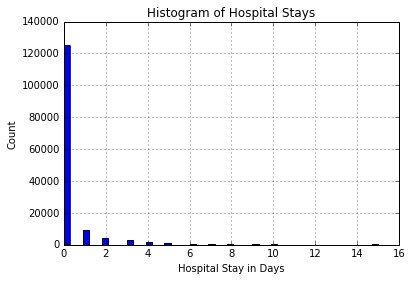

In [16]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math

# Converting hospital stay back from log
hospital_stays = df_aggregated.map(lambda x: math.exp(float(x['label_agg'])) - 1).collect()
# the histogram of the data
n, bins, patches = plt.hist(hospital_stays, 50)

plt.xlabel('Hospital Stay in Days')
plt.ylabel('Count')
plt.title(r'Histogram of Hospital Stays')
plt.grid(True)

plt.show()

##### 4.A.d.2  Method 2:  Run SQL Queries on Temporary Tables <a name="4.A.d.2"></a>

In [17]:
# In order to run SQL queries on DataFrames, we must first register them as temporary tables
df_aggregated.registerTempTable("aggregated")

##### CORRELATION BETWEEN COUNT OF VARIABLE/VALUE PAIR AND TARGET (DAYSINHOSPITAL)
First, we will use Spark SQL to get the maximum value of the hospital stay and also of the variable/value pair so we can set a common domain and range for scatter plots of each variable/value pair afterwards.

We will see that some of the variable/value pairs clearly do not show any correlation with hospital stay (e.g. ProcedureGroup_ANES, ProcedureGroup_SO, PlaceSvc_Office). We may consider omitting these categorical/value pairs while building models. Some others seem to be more promising as predictors (e.g. PrimaryConditionGroup_HEMTOL, Speciality_Pediatrics).

In [18]:
print "Maximum Hospital Stay is:"
print sql_context.sql("SELECT MAX(label_agg) as max FROM aggregated").map(lambda x: math.exp(x['max']) -1).collect()[0]

max_occur_cat_val = 0

#check what is the maxim count of all variable/value pair
for col_val in all_possible_cat_values:
    maxVal = sql_context.sql("SELECT MAX(" + col_val + ") as max FROM aggregated").map(lambda x: x['max']).collect()[0]
    if maxVal > max_occur_cat_val:
        max_occur_cat_val = maxVal

print "Maximum Occurrence of Categorical Value per year is:"
print max_occur_cat_val

Maximum Hospital Stay is:
15.0
Maximum Occurrence of Categorical Value per year is:
43


**NOTE: This takes a while to run.**

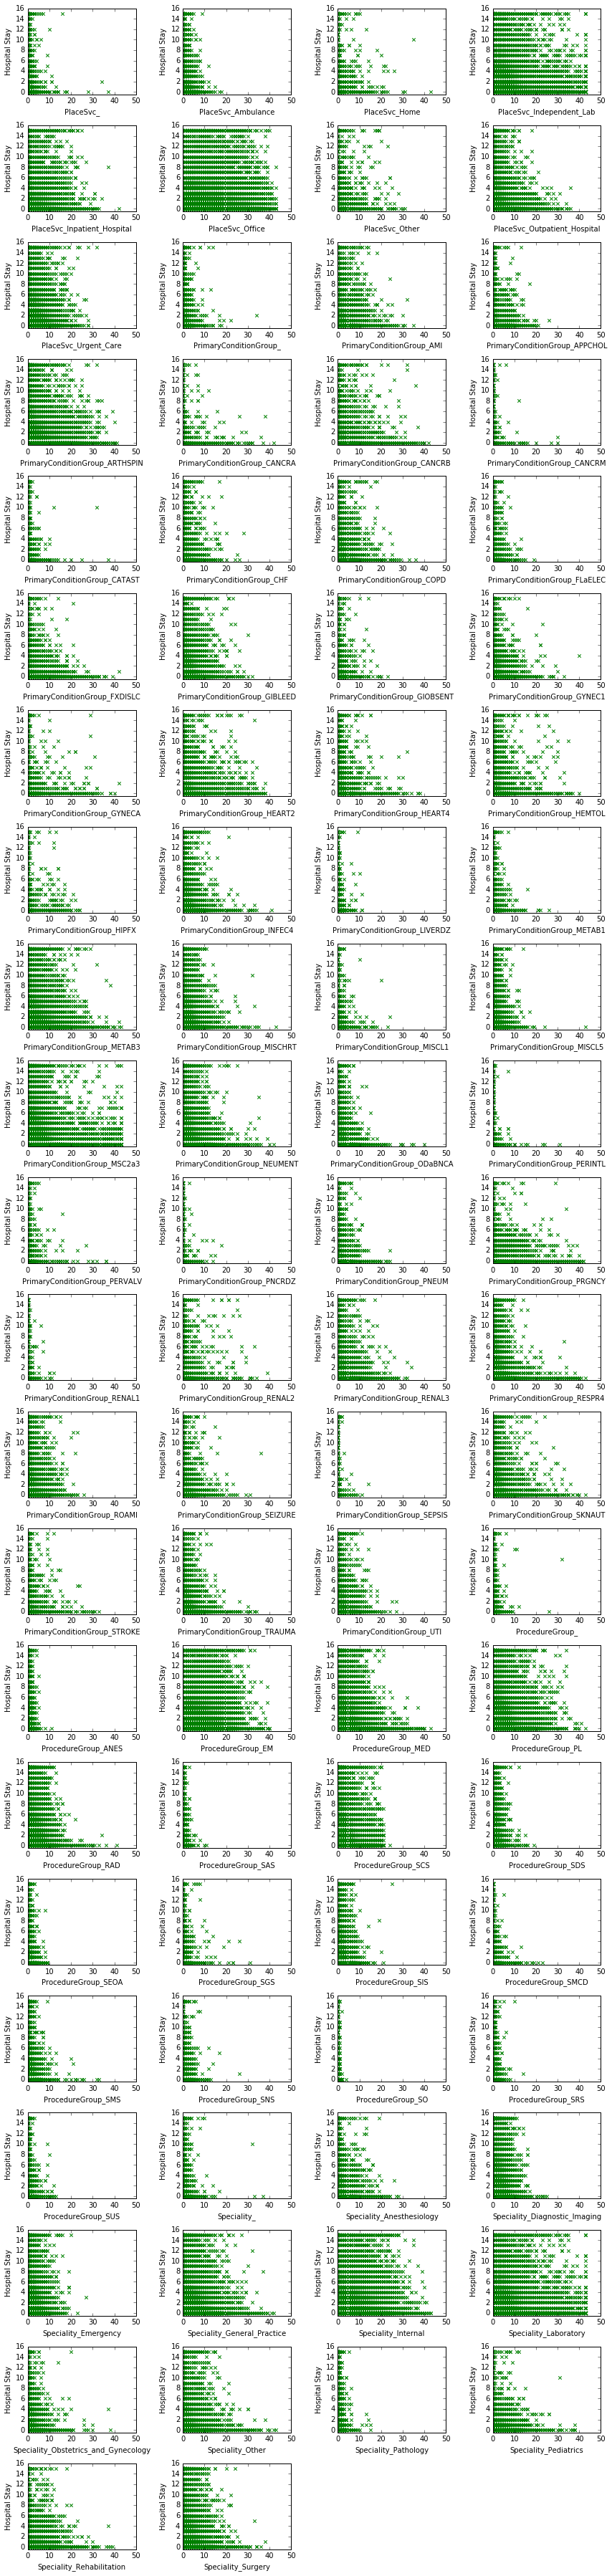

In [18]:
import numpy as np
import matplotlib.pyplot as plt

plt.close('all')
fig = plt.figure()

fig_size = plt.rcParams["figure.figsize"]
 
# Set figure size
fig_size[0] = 12
fig_size[1] = 50
plt.rcParams["figure.figsize"] = fig_size


#plot hospital stay on y axis, count of variable/value pair on x axis
def plot_correlation(sp_h,sp_w,sp_i, col_name):
    
    x_and_y =  sql_context.sql("SELECT label_agg, " + col_name + " from aggregated") \
            .map(lambda x: (x[col_name],math.exp(x.label_agg)-1)).collect()

    x = [a[0] for a in x_and_y]
    y = [a[1] for a in x_and_y]
    
    ax = plt.subplot(sp_h,sp_w,sp_i)
    ax.set_ylabel('Hospital Stay')
    ax.set_xlabel(col_name)
    
    #based on the code above, hardcode x and y-axis so all scatter plots have same domain/range
    ax.set_xlim(0,50)
    ax.set_ylim(-.5,16)
    ax.scatter(x, y,c='green', edgecolor='none',marker='x')

plt.show()

figIndex = 1

#for each variable/value pair, plot hospital stay vs. count of variable/value pair 
for col_name in all_possible_cat_values:
    plot_correlation(22,4,figIndex,col_name)
    figIndex +=1

plt.tight_layout()

# Free up memory
sql_context.dropTempTable("aggregated")

### 4.B  One Hot Encoding <a name="4.B"></a>
[Back to Table of Contents](#TOC)

Here we introduce [Spark's Pipeline feature](https://spark.apache.org/docs/latest/ml-pipeline.html) , which we will use to build a workflow for creating one hot encoded features.

For a great example of using the pipeline feature for one hot encoding, see [here](https://developer.ibm.com/spark/blog/2016/02/22/predictive-model-for-online-advertising-using-spark-machine-learning-pipelines/).

#### 4.B.a  Create DataFrame for One Hot Encoding <a name="4.B.a"></a>
[Back to Table of Contents](#TOC)

We start with the raw members data and build a DataFrame that includes the variables we want to one hot encode:  Age and Sex.

In [19]:
def get_row_array_ohe(line):
    # For reference, columns of data are:
    # ('MemberID', ('AgeAtFirstClaim', 'Sex'))
    row_array = [line[0], # MemberID
                 line[1][0], # AgeAtFirstClaim
                 line[1][1] # Sex
                ]
    return row_array

# Main function to create the DataFrame
def get_dataframe_ohe(rdd):
    
    columns = ["member_id_ohe", "age", "sex"]

    return rdd.map(lambda line: get_row_array_ohe(line)).toDF(columns)

# Create the initial OHE dataframe
df_ohe_initial = get_dataframe_ohe(members)
df_ohe_initial.printSchema()
print 'Number of rows before dropping rows with missing values: %d' %(df_ohe_initial.count())
# Drop rows where numerical variables have missing data
df_ohe_initial = df_ohe_initial.dropna()
print 'Number of rows after dropping rows with missing values: %d' %(df_ohe_initial.count())

root
 |-- member_id_ohe: string (nullable = true)
 |-- age: string (nullable = true)
 |-- sex: string (nullable = true)

Number of rows before dropping rows with missing values: 113000
Number of rows after dropping rows with missing values: 113000


In [20]:
# We do some EDA and find that age and sex can have empty values.  We replace them with 'NA'

# EDA
# Get all possible variable values from an RDD
def get_all_possible_values(line):    
    return line[1] # age and sex
# Get the list of unique new variable names
all_possible_values = sorted(members.flatMap(get_all_possible_values) \
                                       .distinct() \
                                       .collect())
print 'All Possible Values:'
print all_possible_values

# Replace empty values
df_ohe_initial = df_ohe_initial.na.replace('', 'NA', 'age')
df_ohe_initial = df_ohe_initial.na.replace('', 'NA', 'sex')

# Double check data
df_ohe_initial.describe('age', 'sex').show()

All Possible Values:
[u'', u'0-9', u'10-19', u'20-29', u'30-39', u'40-49', u'50-59', u'60-69', u'70-79', u'80+', u'F', u'M']
+-------+------+------+
|summary|   age|   sex|
+-------+------+------+
|  count|113000|113000|
|   mean|  null|  null|
| stddev|  null|  null|
|    min|   0-9|     F|
|    max|    NA|    NA|
+-------+------+------+



#### 4.B.b  One Hot Encode Features Using Spark Pipeline  <a name="4.B.b"></a>
[Back to Table of Contents](#TOC)

We are now ready to use the [StringIndexer](http://spark.apache.org/docs/latest/ml-features.html#stringindexer) and [OneHotEncoder](http://spark.apache.org/docs/latest/ml-features.html#onehotencoder) from spark.ml to one hot encode our categorical variables Age and Sex.  We build a pipeline to accomplish this task.

In [21]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

# Define the String Indexers and the One Hot Encoders
age_indexer = StringIndexer(inputCol="age", outputCol="indexed_age")
age_encoder = OneHotEncoder(inputCol="indexed_age", outputCol="age_vector")

sex_indexer = StringIndexer(inputCol="sex", outputCol="indexed_sex")
sex_encoder = OneHotEncoder(inputCol="indexed_sex", outputCol="sex_vector")

# Define the Pipeline stages for one hot encoding the features
pipeline_ohe = Pipeline(stages=[age_indexer, sex_indexer,
                                age_encoder, sex_encoder])

# Define/Fit the PipelineModel that will run the stages
model_ohe = pipeline_ohe.fit(df_ohe_initial)

# One Hot Encode/Transform the features
df_ohe_intermediate = model_ohe.transform(df_ohe_initial)
print 'One Hot Encoding complete.'

One Hot Encoding complete.


#### 4.B.c  Create DataFrame for Modeling  <a name="4.B.c"></a>
[Back to Table of Contents](#TOC)   

We drop unnecessary variables to get the final DataFrame for modeling.

In [22]:
df_ohe = df_ohe_intermediate.drop('age').drop('sex').drop('indexed_age').drop('indexed_sex')
df_ohe.printSchema()

root
 |-- member_id_ohe: string (nullable = true)
 |-- age_vector: vector (nullable = true)
 |-- sex_vector: vector (nullable = true)



#### 4.B.d   External Storage Read/Write DataFrame  <a name="4.B.d"></a>
[Back to Table of Contents](#TOC)   

In [23]:
# Write to/Read from external storage

# Write DataFrame to external storage
df_ohe.write.save('df_ohe', mode='overwrite')
print 'DataFrame df_ohe written to storage.'

# Read DataFrame from external storage
# df_ohe = sql_context.read.load('df_ohe')
# print 'DataFrame df_ohe read from storage.'

DataFrame df_ohe written to storage.


#### 4.B.e  EDA  <a name="4.B.e"></a>
[Back to Table of Contents](#TOC)

As a best practice, we should do some EDA here on how the Age and Sex variables correlate with our target variable DaysInHospital.

## Import additional packages

In [24]:
from pyspark.sql.functions import exp

In [25]:
df_member_stays = \
    df_aggregated \
    .join(df_ohe_initial,df_aggregated.member_id_agg == df_ohe_initial.member_id_ohe,'left') \
    .select(df_aggregated.member_id_agg,df_aggregated.label_agg, df_ohe_initial.age,df_ohe_initial.sex 
    ) 

In [26]:
df_member_staysForAnalysis = df_member_stays.withColumn("label_agg", exp("label_agg") - 1)

### Take a quick look at member plus hospital stay data and show data types

In [35]:
print("Show 5 records")
df_member_staysForAnalysis.show(5)
print("="*50)
print("Data Types")
df_member_staysForAnalysis.dtypes

Show 5 records
+-------------+---------+---+---+
|member_id_agg|label_agg|age|sex|
+-------------+---------+---+---+
|     10100129|      0.0|80+|   |
|     10100129|      0.0|80+|   |
|     10456576|      0.0|80+|  M|
|     10456576|      0.0|80+|  M|
|     10649860|      0.0|0-9|   |
+-------------+---------+---+---+
only showing top 5 rows

Data Types


[('member_id_agg', 'string'),
 ('label_agg', 'double'),
 ('age', 'string'),
 ('sex', 'string')]

### What are the overall label statistics?

In [36]:
df_member_staysForAnalysis.describe('label_agg').show()

+-------+-------------------+
|summary|          label_agg|
+-------+-------------------+
|  count|             147473|
|   mean|0.45295070962142225|
| stddev| 1.5738178814266126|
|    min|                0.0|
|    max| 14.999999999999998|
+-------+-------------------+



### Create a different data frame for males, females, and unknown sexes

In [37]:
males = df_member_staysForAnalysis.filter(df_member_staysForAnalysis.sex == 'M')
females = df_member_staysForAnalysis.filter(df_member_staysForAnalysis.sex == 'F')
sex_unknown = df_member_staysForAnalysis.filter(df_member_staysForAnalysis.sex == 'NA')

### Check summary statistics for each Sex type

In [43]:
print("      Males")
males.describe('label_agg').show()
print("="*50)
print("     Females")
females.describe('label_agg').show()
print("="*50)
print("     Unknown")
sex_unknown.describe('label_agg').show()

      Males
+-------+------------------+
|summary|         label_agg|
+-------+------------------+
|  count|             53519|
|   mean|0.3069937779106486|
| stddev|1.3400778863651432|
|    min|               0.0|
|    max|14.999999999999998|
+-------+------------------+

     Females
+-------+------------------+
|summary|         label_agg|
+-------+------------------+
|  count|             65873|
|   mean|0.3846644300396217|
| stddev|1.4430319915882168|
|    min|               0.0|
|    max|14.999999999999998|
+-------+------------------+

     Unknown
+-------+---------+
|summary|label_agg|
+-------+---------+
|  count|        0|
|   mean|     null|
| stddev|     null|
|    min|     null|
|    max|     null|
+-------+---------+



### Convert dataframe to pandas dataframe to plot

In [44]:
df_member_staysForAnalysis.toPandas()

,member_id_agg,label_agg,age,sex
0,10100129,0.0,80+,
1,10100129,0.0,80+,
2,10456576,0.0,80+,M
3,10456576,0.0,80+,M
4,10649860,0.0,0-9,
5,10649860,0.0,0-9,
6,11109011,0.0,30-39,M
7,1113857,0.0,70-79,
8,1113857,0.0,70-79,
9,12131763,2.0,30-39,F


### Check distribution of label_agg by gender

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f020594b090>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f0200584d50>]], dtype=object)

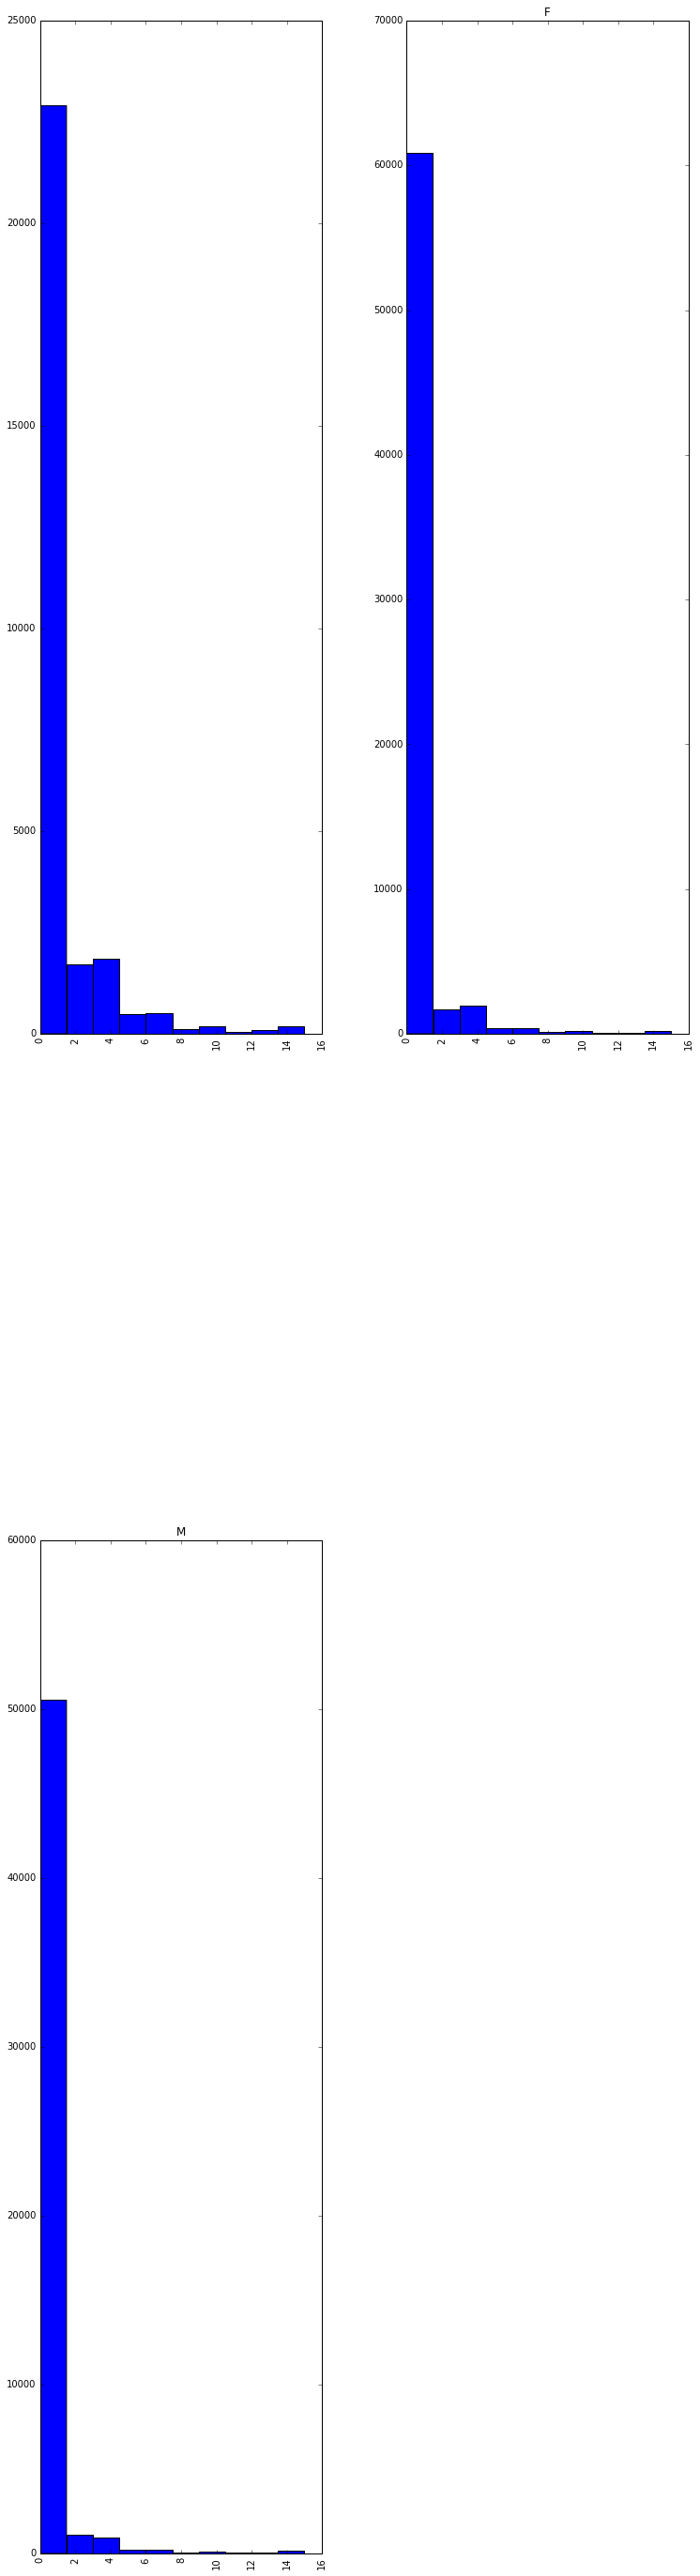

In [45]:
df_member_staysForAnalysis.toPandas()['label_agg'] \
.hist(by=df_member_staysForAnalysis.toPandas()['sex'])

## Now repeat analysis grouped by age

In [49]:
preteens = df_member_staysForAnalysis.filter(df_member_staysForAnalysis.age == '0-9')
teens = df_member_staysForAnalysis.filter(df_member_staysForAnalysis.age == '10-19')
twenties = df_member_staysForAnalysis.filter(df_member_staysForAnalysis.age == '20-29')
thirties = df_member_staysForAnalysis.filter(df_member_staysForAnalysis.age == '30-39')
forties = df_member_staysForAnalysis.filter(df_member_staysForAnalysis.age == '40-49')
fifties = df_member_staysForAnalysis.filter(df_member_staysForAnalysis.age == '50-59')
sixties = df_member_staysForAnalysis.filter(df_member_staysForAnalysis.age == '60-69')
seventies = df_member_staysForAnalysis.filter(df_member_staysForAnalysis.age == '70-79')
eightyplus = df_member_staysForAnalysis.filter(df_member_staysForAnalysis.age == '80+')

In [50]:
print("Age 0-9")
preteens.describe('label_agg').show()
print("="*50)
print("Age 10-19")
teens.describe('label_agg').show()
print("="*50)
print("Age 20-29")
twenties.describe('label_agg').show()
print("="*50)
print("Age 30-39")
thirties.describe('label_agg').show()
print("="*50)
print("Age 40-49")
forties.describe('label_agg').show()
print("="*50)
print("Age 50-59")
fifties.describe('label_agg').show()
print("="*50)
print("Age 60-69")
sixties.describe('label_agg').show()
print("="*50)
print("Age 70-79")
seventies.describe('label_agg').show()
print("="*50)
print("Age 80+")
eightyplus.describe('label_agg').show()

Age 0-9
+-------+-------------------+
|summary|          label_agg|
+-------+-------------------+
|  count|              12823|
|   mean|0.16735553302659284|
| stddev| 0.6947479411789137|
|    min|                0.0|
|    max| 14.999999999999998|
+-------+-------------------+

Age 10-19
+-------+-------------------+
|summary|          label_agg|
+-------+-------------------+
|  count|              13004|
|   mean|0.14856967087050138|
| stddev| 0.6382512949597664|
|    min|                0.0|
|    max| 14.999999999999998|
+-------+-------------------+

Age 20-29
+-------+------------------+
|summary|         label_agg|
+-------+------------------+
|  count|              8604|
|   mean|0.4027196652719665|
| stddev| 1.236790078761458|
|    min|               0.0|
|    max|14.999999999999998|
+-------+------------------+

Age 30-39
+-------+-------------------+
|summary|          label_agg|
+-------+-------------------+
|  count|              14206|
|   mean|0.30480078839926794|
| stddev

### Convert dataframe to pandas dataframe to plot

In [51]:
df_member_staysForAnalysis.toPandas()

,member_id_agg,label_agg,age,sex
0,10100129,0.0,80+,
1,10100129,0.0,80+,
2,10456576,0.0,80+,M
3,10456576,0.0,80+,M
4,10649860,0.0,0-9,
5,10649860,0.0,0-9,
6,11109011,0.0,30-39,M
7,1113857,0.0,70-79,
8,1113857,0.0,70-79,
9,12131763,2.0,30-39,F


### Check distribution of label_agg by gender

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb2b3155950>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb2ad066190>]], dtype=object)

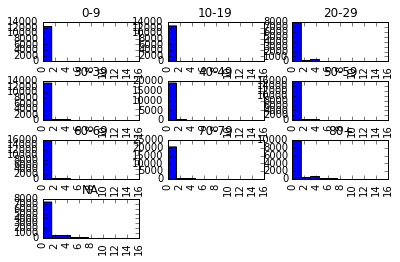

In [29]:
df_member_staysForAnalysis.toPandas()['label_agg'] \
.hist(by=df_member_staysForAnalysis.toPandas()['age'])

## End EPA

### 4.C Year-to-Year Delta Variables <a name="4.C"></a>
[Back to Table of Contents](#TOC)

Yearly changes in the aggregated variables (deltas) might be useful features. For example, if a patient's drugcount increased from Year 1 to Year 2, he/she might more likely stay in hospital during Year 3. For the purpose of this notebook, we will the calculate delta between Year 1 and Year 2.

If we were actually to submit our predictions to this competition, for test data features we would use the delta between Year 2 and Year 3 since the target variable is for Year 4.

**NOTE:  We assume here that if a patient is missing data for a certain year, then they did not have any claims, prescriptions or lab tests in that year.  Then all the aggregated variables for that year are equal to 0.  Thus, if Year 1 data is missing, then all deltas for the aggregated variables are > 0 (everything increased from Year 1 to Year 2).  If Year 2 data is missing, then all deltas for the aggregated variables are < 0 (everything decreased from Year 1 to Year 2).  An alternative approach would be to discard the data of any patient that is missing data in one of the two years and only use patients who we know have true changes from year to year.**

#### 4.C.a  Reduce By MemberID <a name="4.C.a"></a>
[Back to Table of Contents](#TOC)

We first reduce the aggregated data by MemberID so we can put features for both years for a given MemberID in one row.

In [30]:
def reduce_and_make_tuple(first,second):
    return (first[0],second[0])

#map - reduce training data by memberId so we can calculate delta 
reduced_by_member_id = train_data_agg.mapValues(lambda x: (x,None)) \
                                     .reduceByKey(reduce_and_make_tuple)

#### 4.C.b  Functions for Calculating Deltas <a name="4.C.b"></a>
[Back to Table of Contents](#TOC)

In [31]:
# Look for integer in specified index - index could be tuple if integer is within array within array, etc.
# If not found return 0 via try/catch
def lookup_value(indices, all_columns):

    try:
        if type(indices) is tuple:  # actual value is nested within tuple
            if len(indices) == 2:
                return float(all_columns[indices[0]][indices[1]])
            else:   # it's a dictionary of count of variable-value pairs
                if indices[1] in all_columns[indices[0]]:
                    return float(all_columns[indices[0]][indices[1]])
                else: 
                    return 0.0         
        else:   # normal number/int
            return float(all_columns[int(indices)])        
    except:   # if value is not found in a specified place just return zero 
              # e.g. Y2 did not have drug count for memberId 12345678
        return 0.0
    
# Return an array including delta for each requested indices_of_columns
def get_delta_array(row, prev_year, next_year, indices_of_columns): 
    
    delta_array = []   # Store delta for all requested features (specified in indices_of_columns)
    
    if row[1] is None:   # Data for either year is missing - no subtraction is necessary!
        only_data = row[0]
        for indices in indices_of_columns:
            if only_data[len(only_data) - 1] == prev_year:   # only previous year's data is available, 
                                                             # that means number decreased                
                delta_array.append(-lookup_value(indices, only_data))
            if only_data[len(only_data) - 1] == next_year: # only next year's data is available        
                delta_array.append(lookup_value(indices, only_data))

# Use this code if you want to have missing data if both years are not available
#         only_data = row[0]
#         for indices in indices_of_columns:
#             if only_data[len(only_data) - 1] == prev_year:   # only previous year's data is available, 
#                                                              # that means number decreased                
#                 delta_array.append(None)
#             if only_data[len(only_data) - 1] == next_year: #only next year's data is available        
#                 delta_array.append(None)

                
    else:  # Data is available for both years
        
        #find out which array is for previous/next year
        if row[0][len(row[0])-1] == prev_year:
            prev_yr_data = row[0]
            next_yr_data = row[1]
        else:
            prev_yr_data = row[1]
            next_yr_data = row[0]
            
        for indices in indices_of_columns: # Perform subtraction for all requested indices and append to delta array 
            delta_array.append(lookup_value(indices, next_yr_data) - lookup_value(indices, prev_yr_data))
            
    return delta_array
            

#### 4.C.c  Calculate Deltas <a name="4.C.c"></a>
[Back to Table of Contents](#TOC)

We did not calculate deltas for every aggregated variable.  Using intuition as to what might be most predictive, we limited our calculation of the deltas to the below aggregates:

1. Count of Length of Stay
2. Sum of Length Of Stay
3. Specialty_Emergency
4. PlaceSvc_Inpatient_Hospital
5. Count of LabCount
6. Count of DrugCount
7. ProcedureGroup_EM
8. Sum of DrugCount
9. Sum of PayDelay
10. PrimaryConditionGroup_RENAL2
11. Sum of LabCount

In [32]:
# Flatten tuple with two arrays into one array, and also move year to the very end 
def flatten_after_delta(row): 
    len_first_array = len(row[0])
    year = row[0][len_first_array - 1]
    return row[0][:(len_first_array - 1)] + row[1] + [year]

train_data_delta = train_data_agg.leftOuterJoin \
                                  (reduced_by_member_id.mapValues(lambda x: get_delta_array(x,'Y2','Y3',
                                                             [(3, 4), # LengthOfStay.daysCount
                                                              (3, 0), # LengthOfStay.daysSum"
                                                              (5, 76, "c"), # Categorical Var 'Speciality_Emergency
                                                              (5, 4, "c"), # PlaceSvc_Inpatient Hospital
                                                              (2, 4), # LabCountCount
                                                              (1, 4), # DrugCountCount
                                                              (5, 57, "c"), # ProcedureGroup_EM
                                                              (1, 0),  # SumOfDrugCount
                                                              (4, 0), # PayDelaySum
                                                              (5, 45, "c"), # PrimaryConditionGroup_RENAL2
                                                              (2, 0)]))) \
                                 .mapValues(flatten_after_delta)    

print '\nColumns of data are:'
print '(memberId,'
print '[(ClaimsTruncated, DaysInHospital),'
print '(sumDrugCount, minDrugCount, maxDrugCount, averageDrugCount, countOfDrugRecords),'
print '(sumLabCount, minLabCount, maxLabCount, averageLabCount, countOfLabRecords),'
print '(sumLengthOfStay, minLengthOfStay, maxLengthOfStay, averageLengthOfStay, countOfLOSRecords),'
print '(sumPayDelay, minPayDelay, maxPayDelay, averagePayDelay, countOfPDRecords),'
print '{dictionary of count of "Variable_Value" variables in Claims data aggregated by year},'
print 'delta_Count_of_Length_of_Stay, delta_Sum_of_Length_Of_Stay, delta_Specialty_Emergency,'
print 'delta_PlaceSvc_Inpatient_Hospital, delta_Count_of_LabCount, delta_Count_of_DrugCount, delta_ProcedureGroup_EM'
print 'delta_Sum_of_DrugCount, delta_Sum_of_PayDelay, delta_PrimaryConditionGroup_RENAL2,'
print 'delta_Sum_of_LabCount'
print 'targetYearIdentifier])'

print train_data_delta.first()


Columns of data are:
(memberId,
[(ClaimsTruncated, DaysInHospital),
(sumDrugCount, minDrugCount, maxDrugCount, averageDrugCount, countOfDrugRecords),
(sumLabCount, minLabCount, maxLabCount, averageLabCount, countOfLabRecords),
(sumLengthOfStay, minLengthOfStay, maxLengthOfStay, averageLengthOfStay, countOfLOSRecords),
(sumPayDelay, minPayDelay, maxPayDelay, averagePayDelay, countOfPDRecords),
{dictionary of count of "Variable_Value" variables in Claims data aggregated by year},
delta_Count_of_Length_of_Stay, delta_Sum_of_Length_Of_Stay, delta_Specialty_Emergency,
delta_PlaceSvc_Inpatient_Hospital, delta_Count_of_LabCount, delta_Count_of_DrugCount, delta_ProcedureGroup_EM
delta_Sum_of_DrugCount, delta_Sum_of_PayDelay, delta_PrimaryConditionGroup_RENAL2,
delta_Sum_of_LabCount
targetYearIdentifier])
('70256714', [(0.0, 0.0), (1.0, 1.0, 1.0, 1.0, 1.0), (7.0, 7.0, 7.0, 7.0, 1.0), (94.0, 26.0, 42.0, 31.333333333333332, 3.0), (0.0, 0.0, 0.0, 0.0, 3.0), {3: 2, 36: 3, 5: 1, 77: 1, 79: 2, 57: 1

#### 4.C.d  Create DataFrame <a name="4.C.d"></a>
[Back to Table of Contents](#TOC)

In [33]:
def get_row_array_delta(line):
    # For reference, columns of data are:
    # (memberId,
    # [(ClaimsTruncated, DaysInHospital),
    # (sumDrugCount, minDrugCount, maxDrugCount, averageDrugCount, countOfDrugRecords),
    # (sumLabCount, minLabCount, maxLabCount, averageLabCount, countOfLabRecords),
    # (sumLengthOfStay, minLengthOfStay, maxLengthOfStay, averageLengthOfStay, countOfLOSRecords),
    # (sumPayDelay, minPayDelay, maxPayDelay, averagePayDelay, countOfPDRecords),
    # {dictionary of count of "Variable_Value" variables in Claims data aggregated by year},
    # delta_Count_of_Length_of_Stay, delta_Sum_of_Length_Of_Stay, delta_Specialty_Emergency,
    # delta_PlaceSvc_Inpatient_Hospital, delta_Count_of_LabCount, delta_Count_of_DrugCount, delta_ProcedureGroup_EM
    # delta_Sum_of_DrugCount, delta_Sum_of_PayDelay, delta_PrimaryConditionGroup_RENAL2, delta_Sum_of_LabCount
    # targetYearIdentifier])

    row_array = [line[0],       # MemberID
                 line[1][17],   # targetYearIdentifier
                 line[1][0][1], # label = DaysInHospital 
                 line[1][6],    # delta_Count_of_Length_of_Stay
                 line[1][7],    # delta_Sum_of_Length_Of_Stay
                 line[1][11],   # delta_Count_of_DrugCount
                 line[1][13],   # delta_Sum_of_DrugCount
                 line[1][10],   # delta_Count_of_LabCount
                 line[1][16],   # delta_Sum_of_LabCount
                 line[1][14],   # delta_Sum_of_PayDelay
                 line[1][8],    # delta_Specialty_Emergency
                 line[1][9],    # delta_PlaceSvc_Inpatient_Hospital
                 line[1][12],   # delta_ProcedureGroup_EM
                 line[1][15]    # delta_PrimaryConditionGroup_RENAL2
                ]
    return row_array

# Main function to create the DataFrame
def get_dataframe_delta(rdd):
    
    columns = ["member_id_delta", "target_year_delta", "label_delta", "delta_Count_of_Length_of_Stay",
               "delta_Sum_of_Length_Of_Stay", "delta_Count_of_DrugCount", "delta_Sum_of_DrugCount",
               "delta_Count_of_LabCount", "delta_Sum_of_LabCount", "delta_Sum_of_PayDelay",
               "delta_Specialty_Emergency", "delta_PlaceSvc_Inpatient_Hospital", "delta_ProcedureGroup_EM",
               "delta_PrimaryConditionGroup_RENAL2"]

    return rdd.map(lambda line: get_row_array_delta(line)).toDF(columns)

# Create the Deltas dataframe
df_delta = get_dataframe_delta(train_data_delta)
df_delta.printSchema()
print 'Number of rows before dropping rows with missing values: %d' %(df_delta.count())
# Drop rows where target year is not Y3
df_delta = df_delta.filter(df_delta.target_year_delta == 'Y3').dropna()
print 'Number of rows after dropping rows with missing values: %d' %(df_delta.count())

root
 |-- member_id_delta: string (nullable = true)
 |-- target_year_delta: string (nullable = true)
 |-- label_delta: double (nullable = true)
 |-- delta_Count_of_Length_of_Stay: double (nullable = true)
 |-- delta_Sum_of_Length_Of_Stay: double (nullable = true)
 |-- delta_Count_of_DrugCount: double (nullable = true)
 |-- delta_Sum_of_DrugCount: double (nullable = true)
 |-- delta_Count_of_LabCount: double (nullable = true)
 |-- delta_Sum_of_LabCount: double (nullable = true)
 |-- delta_Sum_of_PayDelay: double (nullable = true)
 |-- delta_Specialty_Emergency: double (nullable = true)
 |-- delta_PlaceSvc_Inpatient_Hospital: double (nullable = true)
 |-- delta_ProcedureGroup_EM: double (nullable = true)
 |-- delta_PrimaryConditionGroup_RENAL2: double (nullable = true)

Number of rows before dropping rows with missing values: 147473
Number of rows after dropping rows with missing values: 71435


#### 4.C.e  External Storage Read/Write DataFrame <a name="4.C.e"></a>
[Back to Table of Contents](#TOC)

In [34]:
# Write to/Read from external storage

# Write DataFrame to external storage
df_delta.write.save('df_delta', mode='overwrite')
print 'DataFrame df_delta written to storage.'

# Read DataFrame from external storage
# df_delta = sql_context.read.load('df_delta')
# print 'DataFrame df_delta read from storage.'

DataFrame df_delta written to storage.


#### 4.C.f  EDA <a name="4.C.f"></a>
[Back to Table of Contents](#TOC)

As a best practice, we should do some EDA here on how the Delta variables correlate with our target variable DaysInHospital.

In [ ]:
# To do